In [23]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [24]:
torch.manual_seed(2017)
with open('./data.txt', 'r') as f:
    data_list = [i.split('\n')[0].split(',') for i in f.readlines()]
    data = [(float(i[0]), float(i[1]), float(i[2])) for i in data_list]
x0_max = max([i[0] for i in data])
x1_max = max([i[1] for i in data])

x0 = list(filter(lambda x: x[-1] == 0.0,data))
x1 = list(filter(lambda x: x[-1] == 1.0, data))

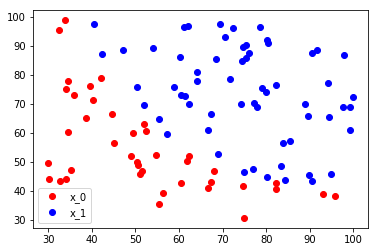

In [25]:
plot_x0 = [i[0] for i in x0]
plot_y0 = [i[1] for i in x0]
plot_x1 = [i[0] for i in x1]
plot_y1 = [i[1] for i in x1]

plt.plot(plot_x0, plot_y0, 'ro', label='x_0')
plt.plot(plot_x1, plot_y1, 'bo', label='x_1')
plt.legend(loc='best')

In [26]:
np_data = np.array(data,dtype='float32')
x_data = torch.from_numpy(np_data[:,0:2])
y_data = torch.from_numpy(np_data[:,-1]).unsqueeze(1)

In [27]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

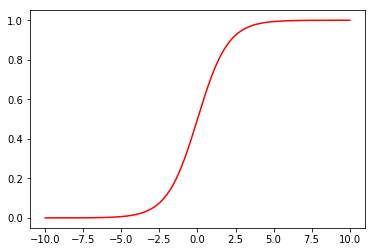

In [28]:
plot_x = np.arange(-10,10.01,0.01)
plot_y = sigmoid(plot_x)
plt.plot(plot_x,plot_y,'r')

In [30]:
x_data = Variable(x_data)
y_data = Variable(y_data)

In [32]:
import torch.nn.functional as F
w = Variable(torch.randn(2, 1), requires_grad=True) 
b = Variable(torch.zeros(1), requires_grad=True)

def logistic_regression(x):
    return F.sigmoid(torch.mm(x, w) + b)